In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [3]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [4]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [12]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
returns = cad_jpy_df['Price'].pct_change().dropna() * 100
# In this case, you may have to replace inf, -inf values with np.nan"s
cad_jpy_df['Return'] = returns.copy()
returns.head()

Date
1990-01-05    0.874777
1990-01-08   -0.216798
1990-01-09    0.667901
1990-01-10    0.567546
1990-01-11    0.031794
Name: Price, dtype: float64

### Lagged Returns 

In [10]:
# Create a lagged return using the shift function
cad_jpy_df['Lagged_Return'] = returns.shift()
cad_jpy_df.dropna(inplace=True)
cad_jpy_df.head()

,Price,Open,High,Low,Lagged_Return
Date,,,,,
1990-01-04,123.46,123.41,123.46,123.41,-0.846720
1990-01-05,124.54,124.48,124.54,124.48,-1.468476
1990-01-08,124.27,124.21,124.27,124.21,0.874777
1990-01-09,125.10,125.04,125.10,125.04,-0.216798
1990-01-10,125.81,125.75,125.81,125.75,0.667901


### Train Test Split

In [34]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':]
train.dropna(inplace=True)

In [56]:
test.head()

,Price,Open,High,Low,Lagged_Return,Return
Date,,,,,,
2018-01-01,89.80,89.59,89.83,89.56,-0.256096,0.245591
2018-01-02,89.75,89.83,90.00,89.39,0.245591,-0.055679
2018-01-03,89.76,89.76,89.84,89.51,-0.055679,0.011142
2018-01-04,90.30,89.75,90.32,89.69,0.011142,0.601604
2018-01-05,91.13,90.31,91.61,90.23,0.601604,0.919158


In [58]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
X_train = train['Lagged_Return'].to_frame()
X_test = test["Lagged_Return"].to_frame()

# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
y_train = train["Return"] #.values.reshape(-1, 1)
y_test = test["Return"] #.values.reshape(-1, 1)

In [59]:
# Preview the X_train data
X_train.head()

,Lagged_Return
Date,
1990-01-05,-1.468476
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901
1990-01-11,0.567546


In [60]:
y_test.head()

Date
2018-01-01    0.245591
2018-01-02   -0.055679
2018-01-03    0.011142
2018-01-04    0.601604
2018-01-05    0.919158
Name: Return, dtype: float64

# Linear Regression Model

In [38]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):


In [61]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [62]:
# Make a prediction of "y" values using just the test dataset
predictions_y_test = model.predict(X_test)

In [63]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results['Predicted_Return'] = predictions_y_test

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

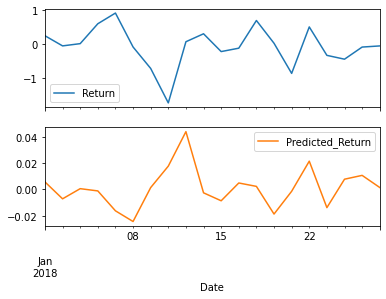

In [64]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [67]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)
mse = mean_squared_error(
    Results['Return'],
    Results['Predicted_Return']
)

rmse = np.sqrt(mse)


# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
print(rmse)

0.6445688966240931


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [72]:
# Construct a dataframe using just the "y" training data:
sample_results = y_train.to_frame()


# Add a column of "in-sample" predictions to that dataframe:  
sample_results['in-smaple-predictions'] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
sample_mse = mean_squared_error(
    sample_results['Return'],
    sample_results['in-smaple-predictions']
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
sample_rse = np.sqrt(sample_mse)
print(f"My sample Root Mean Squared Error (RMSE) is: {sample_rse}")

My sample Root Mean Squared Error (RMSE) is: 0.8418717748614414


# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:** YOUR ANSWER HERE

In [73]:
print(f"The out of sample RMSE results fit the best since this RMSE of 0.644 is lower than 0.841 from the in-sample")

The out of sample RMSE results fit the best since this RMSE of 0.644 is lower than 0.841 from the in-sample
